In [1]:
import numpy as np
import glob, os, string, import_ipynb, copy
from keras import layers as ly
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Lambda, LSTM, Dense, RepeatVector, TimeDistributed
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from scipy.spatial.distance import cosine as cosine_distance
from keras.models import model_from_json
from collections import Counter
import drawingGraph as G
import warnings
import random as rd
warnings.filterwarnings("ignore", category=UserWarning)

Using TensorFlow backend.


importing Jupyter notebook from drawingGraph.ipynb


In [2]:
'''def getIndexFromGraph(filename):
    index = int(filename.split('-')[0].replace('graph', ''))
    return index
'''
def getIndexFromGraph(filename):
    
    index, idx = map(int, (filename.split('REAL')))
    return index, idx

In [3]:
def calculateGraphGroup(num_dict):
    for index, data in enumerate(all_data):

        idx, loc = getIndexFromGraph(graph_group[index])
        num_dict[idx][loc-1] += 1
    return num_dict

In [4]:
def getEmbeddingSum():
    sum_embedding = [[[0 for i in range(embedded_length)] for i in range(per_groups[i])] for i in range(group_count)]
    for index, data in enumerate(all_data):
        data = data.reshape(1, data.shape[0], data.shape[1])
        embedded = encoder.predict(data)
        idx, loc = getIndexFromGraph(graph_group[index])
        sum_embedding[idx][loc-1] += embedded.reshape(embedded.shape[1])
    return sum_embedding

In [5]:
def getEmbeddingAvg():
    avg_embedding = [[[0 for i in range(embedded_length)] for i in range(per_groups[i])] for i in range(group_count)]
    #avg_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    sum_embedding = getEmbeddingSum()
    for i in range(len(all_data)):
        idx, loc = getIndexFromGraph(graph_group[i])
        avg_embedding[idx][loc-1] = sum_embedding[idx][loc-1] / num_dict[idx][loc-1]
    return avg_embedding

In [6]:
def getMode(values):
    values.sort()
    mode = Counter(values).most_common()
    maximum = mode[0][1]
    if maximum == 1:
        return values.mean()
    else:
        dt = []
        for m in mode:
            if maximum == m[1]:
                dt.append(m[0])
            else:
                break
        return np.array(dt).mean()

In [7]:
def getEmbeddingVector(group_num, index):
    data_index = []
    data = []
    counts = num_dict[group_num][index]
    
    for num, i in enumerate(graph_group):
        idx, loc = getIndexFromGraph(i)
        if idx == group_num and loc == index + 1:
            data_index.append(num)
        if len(data_index) == counts:
            break
    
    for i in data_index:
        dt = all_data[i].reshape(1, all_data[i].shape[0], all_data[i].shape[1])
        dt = encoder.predict(dt)
        dt = dt.reshape(dt.shape[1])
        data.append(dt)
    return data

In [8]:
def getEmbeddingMode(): # 최빈값
    mode_embedding = [[[0 for i in range(embedded_length)] for i in range(per_groups[i])] for i in range(group_count)]

    for i in range(group_count):
        for index in range(per_groups[i]):
            #print(index)
            vectors = np.array(getEmbeddingVector(i, index))
            tmp = [0 for i in range(embedded_length)]
            for count in range(embedded_length):
                values = vectors[:, count].reshape(num_dict[i][index])
                tmp[count] = getMode(values)
            mode_embedding[i][index] = tmp
    return mode_embedding

In [9]:
def getEmbeddingExceptMinMax():
    except_embedding = [[[0 for i in range(embedded_length)] for i in range(per_groups[i])] for i in range(group_count)]

    for i in range(group_count):
        for index in range(per_groups[i]):
            vectors = np.array(getEmbeddingVector(i, index))
            tmp = [0 for i in range(embedded_length)]
            for count in range(embedded_length):
                #print(i, index)
                values = vectors[:, count].reshape(num_dict[i][index])
                values.sort()
                tmp[count] = values[1:-1].mean()
            except_embedding[i][index] = tmp
    return except_embedding

In [10]:
def euclidean_distance(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.sum(a-b) ** 2)

In [11]:
def getDistFromEmbedding(distance_measure, embedding, obj):
    if embedding  == 'sum':
        embeddings = sum_embedding
    elif embedding == 'avg':
        embeddings = avg_embedding
    elif embedding == 'mode':
        embeddings = mode_embedding
    elif embedding =='except':
        embeddings = except_embedding
    
    dist = []
    for i in range(group_count):
        for index in range(per_groups[i]):
            if distance_measure == 'euc':
                dist.append(eucliean_distance(obj, embeddings[i][index]))
            else:
                dist.append(cosine_distance(obj, embeddings[i][index]))
    return dist

In [12]:
def getTopData(n, datasets, names):
    data = []
    for i in names[:n+1]:
        data.append(datasets[i])
    return data

In [13]:
def draw(drawobj, drawobj_name, dir_name, save):
    for index, obj in enumerate(drawobj):
        G.drawGraph(dir_name, 'REAL' + str(drawobj_name[index]+1), index, obj, save)

In [58]:

#filename = 'kldoh_real_model' #input('filename: ')
json_file = open("models/real/2REAL_kld_real_model.json", "r") #"+filename+"
loaded_model_json = json_file.read() 
lstm_autoencoder = model_from_json(loaded_model_json)
lstm_autoencoder.load_weights('models/real/2weights_REAL_kld_real_model.h5')
'''
#filename = 'kldoh_real_model' #input('filename: ')
json_file = open("models/related/REAL_rnn_ae_model1.json", "r") #"+filename+"
loaded_model_json = json_file.read() 
lstm_autoencoder = model_from_json(loaded_model_json)
lstm_autoencoder.load_weights('models/related/weights_REAL_rnn_ae_model1.h5')
'''

'\n#filename = \'kldoh_real_model\' #input(\'filename: \')\njson_file = open("models/related/REAL_rnn_ae_model1.json", "r") #"+filename+"\nloaded_model_json = json_file.read() \nlstm_autoencoder = model_from_json(loaded_model_json)\nlstm_autoencoder.load_weights(\'models/related/weights_REAL_rnn_ae_model1.h5\')\n'

In [59]:
chr2index = {'C':1, 'N':2, 'O':3, 'F':4, 'P':5, 'S':6, 'Cl':7, 'As': 8, 'I':9, 'Hg':10}

In [60]:
def chr2OH(alphabet):
    oh = [0 for i in range(len(chr2index))]
    index = chr2index[alphabet] -1
    oh[index] = 1
    return oh

In [61]:
chr2OH('Cl')

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [62]:
dir = './REAL/group/*'

graph_group = []
chr_data = []
all_data = []
sequence_length = []
alpha = list(string.ascii_uppercase)
data_length = len(glob.glob(dir))
file_predix = './REAL/seq/'

for index in range(data_length):
    filename = file_predix + str(index) + "/*"
    #print(filename)
    count = 0
    files = sorted(glob.glob(filename))
    for file in files:
        datasets = []
        chr_dts = []
        graph_group.append(file.split('/')[-1].replace('.txt', '').split('-')[0].replace('graph', '_'))
        #ind = file.split('/')[-1].replace('.txt', '').split('-')[0].replace('graph', '_')
        #if ind.split('_')[1] == '1':
        #    print(ind, len(all_data))
        for rf in open(file, 'r'):
            (u, v, w) = rf[1:-2].split(', ')
            chr_dts.append([u[1:-1], v[1:-1], w])
            #datasets.append(chr2OH(u[1:-1]) + chr2OH(v[1:-1])) #+[float(w)])
            datasets.append(chr2OH(u[1:-1]) + chr2OH(v[1:-1]) +[float(w)])
            #datasets.append([chr2index[u[1]], chr2index[v[1]], float(w)])
        sequence_length.append(len(datasets))
        all_data.append(datasets)
        chr_data.append(chr_dts)
        count += 1
all_data = np.array([np.array(arr) for arr in all_data])

In [63]:
len(all_data)

1968

In [64]:
graph_length = 100#1080 #1260#len(glob.glob('./latest_graph_data/*')) 
embedded_length = 64
group_count = 5
per_groups = [20, 20, 20, 20, 20]

In [65]:
encoder = Model(lstm_autoencoder.input, lstm_autoencoder.layers[2].output)

In [66]:
num_dict = { i:{j:0 for j in range(per_groups[i])} for i in range(group_count)}
num_dict = calculateGraphGroup(num_dict)

In [77]:
import time
start = time.time()

In [78]:
sum_embedding = getEmbeddingSum()

In [79]:
avg_embedding = getEmbeddingAvg()

In [80]:
mode_embedding = getEmbeddingMode()

In [81]:
except_embedding = getEmbeddingExceptMinMax()

In [82]:
end=time.time()
end-start

48.20634651184082

In [191]:
count = 0

print(except_embedding[0][0][0:5])
print(except_embedding[0][19][0:5])
print(except_embedding[1][0][0:5])
    

[0.4599817, 0.037959915, 0.06284111, -0.059399534, -0.49337682]
[0.37044027, 0.0069670486, 0.0048034606, -0.22738644, -0.5588526]
[0.2021118, 0.08335173, 0.09140948, -0.030363292, -0.11809695]


In [192]:
print(cosine_distance(except_embedding[0][0], except_embedding[0][9]))
print(cosine_distance(except_embedding[0][0], except_embedding[1][0]))


0.05677294731140137
0.3762059807777405


In [29]:
def getIndexes(index):
    index_range = [0, 20, 40, 60, 80, 100]
    m = index;
    for j in range(1,len(index_range)+1):
        if m<index_range[j]:
            x =  j-1
            y = m-index_range[j-1]
            break
    return x, y

In [30]:
def getGraphOrder(dist):
    ordered = copy.deepcopy(dist)
    ordered.sort()
    #print(len(dist))
    names = []
    check = [[0 for i in range(per_groups[i])] for i in range(group_count)]
    #print(check)
    for item in ordered:
        for index, d in enumerate(dist):
            x, y = getIndexes(index)
            #print(index, x, y)
            if item == d and not check[x][y]:
                names.append(index)#+1)
                check[x][y] = 1
                break
            
    return names, ordered

In [31]:
def calcuPrecision(arr, ans):
    cnt = 0
    global dt
    for index, a in enumerate(arr):
        if index == 0:
            continue
        x, y = getIndexes(a)
        dt[x] += 1
        if ans==x:
            cnt = cnt+1
    return cnt

In [32]:
test = [[12, 3, 19, 18, 1], [10, 4, 14, 5, 3], [6, 11, 15, 18, 2], [13, 10, 6, 9, 5], [17, 10, 19, 2, 8]]

In [71]:
tmp = [i for i in range(0, 20)]
for cond in [0, 1, 2, 3, 4]:
    prec = 0
    #dt = [0 for i in range(group_count)]
    rd.shuffle(tmp)
    for n in tmp[:5]:
    #for n in test[cond]:
        #print(cond, n)
        dt = [0 for i in range(group_count)]
        obj =  avg_embedding[cond][n-1]
        dist = []
        name = []
        for i, ee in enumerate(avg_embedding):
            for index, em in enumerate(ee):
                dist.append(cosine_distance(obj, em))
                name.append(str(i)+'_'+str(index+1))
        ordered_dist = sorted(dist)
        n = set()
        for i, od in enumerate(ordered_dist):
            if i >= 20:
                break
            for idx, d in enumerate(dist):
                if od == d and idx not in n:
                    #print(name[idx], end=' ')
                    n.add(idx)
                    break
        prec += calcuPrecision(n, cond)
        #print(dt)
        for d in dt:
            print(d, end= ' ')
        print()
    #print(cond, prec)

18 1 0 0 0 
18 1 0 0 0 
17 2 0 0 0 
18 1 0 0 0 
17 2 0 0 0 
0 19 0 0 0 
4 15 0 0 0 
0 17 0 2 0 
0 19 0 0 0 
0 19 0 0 0 
0 0 18 0 1 
0 0 15 0 4 
0 0 18 0 1 
0 0 18 0 1 
0 0 19 0 0 
0 0 0 18 1 
0 0 0 13 6 
0 0 0 16 3 
0 0 0 18 1 
0 0 0 18 1 
0 0 0 0 19 
0 0 0 0 19 
0 0 0 0 19 
0 0 0 0 19 
0 0 0 0 19 


In [72]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score

for cond in [0, 1, 2, 3, 4]:
    prec = 0
    #print(dt)
    rd.shuffle(tmp)
    for n in test[cond]:
        dt = [0 for i in range(group_count)]
        #print(cond, n)
        obj =  except_embedding[cond][n-1]
        dist = []
        name = []
        for i, ee in enumerate(except_embedding):
            for index, em in enumerate(ee):
                #dist.append(cosine_distance(obj, em))
                dist.append(cosine_similarity([obj], [em])[0][0])
                name.append(str(i)+'_'+str(index+1))
        #print(dist)
        y_true = [0 for i in range(100)]
        for i in range(20*cond, 20*(cond+1)):
            y_true[i]= 1
        #print(np.array(y_true), np.array(dist))
        print(roc_auc_score(np.array(y_true), np.array(dist)))
        '''
        for d in dt:
            print(d, end= ' ')
        print()
        '''
        #print(cond, prec)

0.985
0.9974999999999999
0.9974999999999999
0.9974999999999999
0.99875
0.99875
1.0
1.0
0.9662499999999999
1.0
0.9825
0.99625
0.9987499999999999
0.999375
0.996875
0.9987499999999999
0.998125
0.9868750000000001
0.9999999999999999
0.9812500000000001
1.0
0.999375
0.9999999999999999
0.9981249999999999
1.0


In [57]:
cond = rd.randint(0, 2)
cond = 3
at = 20

n = rd.randint(0, at)
n = 12
print(cond, n+1)
obj = except_embedding[cond][n]
dist = []
name = []
for i, ee in enumerate(except_embedding):
    for index, em in enumerate(ee):
        dist.append(cosine_distance(obj, em))
        name.append(str(i)+'_'+str(index+1))

ordered_dist = sorted(dist)
n = set()
for i, od in enumerate(ordered_dist):
    #print(od)
    for idx, d in enumerate(dist):
        if od == d and idx not in n:
            print(name[idx])
            n.add(idx)
            break


3 13
3_13
3_15
3_9
3_11
3_17
3_19
3_14
4_7
3_7
3_1
3_2
4_18
1_17
1_11
1_18
4_6
2_15
4_15
4_5
4_3
4_14
4_16
4_20
3_16
4_1
1_14
3_8
1_19
3_12
4_8
4_17
4_11
4_2
3_18
4_19
4_9
4_12
3_5
3_20
4_4
4_13
4_10
3_6
2_7
2_19
2_20
2_18
2_2
2_12
2_14
2_10
3_3
3_4
2_1
2_9
2_3
2_8
2_11
2_17
2_5
2_4
2_16
2_6
3_10
1_2
2_13
1_1
1_7
1_15
1_4
1_9
1_3
1_16
1_8
1_12
0_8
1_20
1_10
1_6
0_12
0_9
0_17
0_13
0_10
1_5
1_13
0_19
0_20
0_16
0_2
0_18
0_14
0_15
0_6
0_3
0_11
0_4
0_7
0_5
0_1


In [243]:
for k in range(17):
    print(k+1)
    obj = except_embedding[0][k]
    for _, ee in enumerate(except_embedding):
        for index, em in enumerate(ee):
            print(index, cosine_distance(obj, em))
    print()
print("++++++++++++++++++++++++++++++++++++++++++")
for k in range(6):
    print(k+1)
    obj = except_embedding[1][k]
    for _, ee in enumerate(except_embedding):
        for index, em in enumerate(ee):
            print(index, cosine_distance(obj, em))
    print()
print("++++++++++++++++++++++++++++++++++++++++++")
for k in range(5):
    print(k+1)
    obj = except_embedding[2][k]
    for _, ee in enumerate(except_embedding):
        for index, em in enumerate(ee):
            print(index, cosine_distance(obj, em))
    print()

1
0 0.0
1 0.23758739233016968
2 0.10017508268356323
3 0.09950876235961914
4 0.09931385517120361
5 0.24241983890533447
6 0.10206562280654907
7 0.35710299015045166
8 0.3176637887954712
9 0.36948806047439575
10 0.10017508268356323
11 0.31473487615585327
12 0.33349233865737915
13 0.19734609127044678
14 0.24215352535247803
15 0.24905073642730713
16 0.2733948230743408
17 0.24906325340270996
18 0.3441692590713501
19 0.3475341796875
0 0.7338504493236542
1 0.7213927507400513
2 0.7293432950973511
3 0.7065165042877197
4 0.7442355155944824
5 0.725226491689682
6 0.736724466085434
7 0.6556645035743713
8 0.738774836063385
9 0.7162700295448303
10 0.7748930752277374
11 0.739644318819046
12 0.7344035506248474
13 0.7529809772968292
14 0.6980765461921692
15 0.7277632057666779
16 0.8078901022672653
17 0.7873591631650925
18 0.8020196706056595
19 0.6717785000801086
0 0.745711088180542
1 0.7439256608486176
2 0.7409489452838898
3 0.7526061981916428
4 0.7748444527387619
5 0.7543985545635223
6 0.7499257624149323

0 0.34738636016845703
1 0.32987886667251587
2 0.33350300788879395
3 0.3404489755630493
4 0.36873579025268555
5 0.3474971055984497
6 0.34544116258621216
7 0.33651214838027954
8 0.34738636016845703
9 0.3192874789237976
10 0.3214225172996521
11 0.3457280397415161
12 0.3511715531349182
13 0.357414186000824
14 0.36411476135253906
15 0.35308295488357544
16 0.37879306077957153
17 0.3347048759460449
18 0.3411863446235657
19 0.34098178148269653
0 0.4352462887763977
1 0.4352462887763977
2 0.39745616912841797
3 0.39745616912841797
4 0.4549545645713806
5 0.3879464864730835
6 0.44410479068756104
7 0.4414554834365845
8 0.41597265005111694
9 0.4026135802268982
10 0.40576785802841187
11 0.45148223638534546
12 0.3869251012802124
13 0.3667820692062378
14 0.4598097801208496
15 0.4083440899848938
16 0.44689565896987915
17 0.4133610725402832
18 0.4479965567588806
19 0.39251673221588135
0 0.36485016345977783
1 0.3742627501487732
2 0.3630417585372925
3 0.38696157932281494
4 0.36629337072372437
5 0.3657059073

12 0.07426738739013672
13 0.010099411010742188
14 0.027803361415863037
15 0.007277786731719971
16 0.0019049644470214844
17 0.0622522234916687
18 0.02377617359161377
19 0.044013142585754395
0 0.21059703826904297
1 0.21059703826904297
2 0.16978931427001953
3 0.16978931427001953
4 0.24063533544540405
5 0.2096957564353943
6 0.19854527711868286
7 0.2071913480758667
8 0.18297940492630005
9 0.19675922393798828
10 0.14438414573669434
11 0.21722614765167236
12 0.15292423963546753
13 0.11377120018005371
14 0.20715290307998657
15 0.1769203543663025
16 0.18130457401275635
17 0.1659591794013977
18 0.15699952840805054
19 0.18232572078704834
0 0.08994090557098389
1 0.10094738006591797
2 0.08717882633209229
3 0.08634841442108154
4 0.08836895227432251
5 0.09071493148803711
6 0.08258616924285889
7 0.09591197967529297
8 0.10494273900985718
9 0.10468101501464844
10 0.1011614203453064
11 0.10336703062057495
12 0.10488826036453247
13 0.083809494972229
14 0.09454500675201416
15 0.09200698137283325
16 0.08691

In [111]:
obj = except_embedding[0][0]
dist_except_cos = getDistFromEmbedding('cos', 'except', except_obj)
names_except_cos, ordered_except_cos = getGraphOrder(dist_except_cos)

In [114]:
for idx, c in enumerate(dist_except_cos):
    print(idx, c)

0 0.4024912118911743
1 0.4519997239112854
2 0.31903165578842163
3 0.44799095392227173
4 0.40055370330810547
5 0.4046217203140259
6 0.36962395906448364
7 0.37033236026763916
8 0.3677106499671936
9 0.37177276611328125
10 0.40881258249282837
11 0.36121320724487305
12 0.4094361662864685
13 0.43242406845092773
14 0.32692134380340576
15 0.3731083273887634
16 0.3789607286453247
17 0.01080024242401123
18 0.004306018352508545
19 0.0003272891044616699
20 0.0019635558128356934
21 0.14618778228759766
22 0.0
23 0.3633970618247986
24 0.3633970618247986
25 0.2665143609046936
26 0.2665143609046936
27 0.3633970618247986


In [110]:
index_range = [0, 17, 23, 28]
ch = [0 for i in range(sum(per_groups))] # 720
mode_precision = 0
avg_precision = 0
except_precision = 0

for t in range(11, 52, 10):
    
    print('t : ', t)
    avg_precision = mode_precision = except_precision = 0
    
    for i in range(0, 2):
        ch = [0 for i in range(sum(per_groups))] # 720
        dist = [0 for i in range(2)]
        for idx in range(10):
            n = rd.randint(index_range[i], index_range[i+1]-1)
            while ch[n] == 1:
                n = rd.randint(index_range[i], index_range[i+1]-1)#n = rd.randint(i-210, i-1)
            ch[n] = 1
            x, y = getIndexes(n)
            #y -=1
            #avg_obj = avg_embedding[x][y]
            #mode_obj = mode_embedding[x][y]
            except_obj = except_embedding[x][y]
            
            #dist_avg_cos = getDistFromEmbedding('cos', 'avg', avg_obj)
            #dist_mode_cos = getDistFromEmbedding('cos', 'mode', mode_obj)
            dist_except_cos = getDistFromEmbedding('cos', 'except', except_obj)
            print(n, x, y, dist_except_cos)
            #names_avg_cos, ordered_avg_cos = getGraphOrder(dist_avg_cos)
            #names_mode_cos, ordered_mode_cos = getGraphOrder(dist_mode_cos)
            names_except_cos, ordered_except_cos = getGraphOrder(dist_except_cos)
            print(n, x, y, names_except_cos[:t])

            #avg_precision += calcuPrecision(names_avg_cos[1:t], x)
            #mode_precision += calcuPrecision(names_mode_cos[1:t], x)

            except_precision += calcuPrecision(names_except_cos[1:t], x)
        print("**"+str(i+1), dist)
    print(avg_precision / (20*(t-1)),mode_precision / (20*(t-1)), except_precision / (20*(t-1)))

t :  11
15 0 15 [0.01121973991394043, 0.028583288192749023, 0.023212909698486328, 0.027480125427246094, 0.01319962739944458, 0.012465119361877441, 0.03834909200668335, 0.017647087574005127, 0.03764623403549194, 0.014012575149536133, 0.0176699161529541, 0.022916793823242188, 0.016778230667114258, 0.016416609287261963, 0.028390467166900635, 0.0, 0.027916908264160156, 0.3925281763076782, 0.3740488290786743, 0.3830336928367615, 0.3830455541610718, 0.3899226784706116, 0.3731083273887634, 0.5712646245956421, 0.5712646245956421, 0.535101592540741, 0.535101592540741, 0.5712646245956421]
15 0 15 [15, 0, 5, 4, 9, 13, 12, 7, 10, 11, 2]
16 0 16 [0.01666104793548584, 0.04351401329040527, 0.0213472843170166, 0.04086953401565552, 0.0100477933883667, 0.042139649391174316, 0.07906752824783325, 0.022264599800109863, 0.05864030122756958, 0.0226251482963562, 0.015045583248138428, 0.009348511695861816, 0.019033968448638916, 0.036361634731292725, 0.024282515048980713, 0.027916908264160156, 0.0, 0.3785218596

IndexError: list index out of range

In [273]:
if top == 11:
    print( avg_precision/600, mode_precision/600, except_precision/600)
elif top == 21:
    print( avg_precision/1200, mode_precision/1200, except_precision/1200)
elif top == 31:
    print( avg_precision/1800, mode_precision/1800, except_precision/1800)
elif top == 51:
    print( avg_precision/3000, mode_precision/3000, except_precision/3000)

In [64]:
    print( avg_precision, mode_precision, except_precision)

0 0 542


In [66]:
#그래프 그리기 위해 각 그래프 그룹 가운데 하나씩 가져옴. (모든 노드에 대한 sequence 에서 하나의 노드 시퀀스만 가져오기) 
datasets = [[] for i in range(graph_length)]
for n, data in zip(graph_group, chr_data):
    i, j = map(int, n.split('HIV'))
    index = 100 * (i-1) + j -1
    if len(datasets[index]) == 0:
        d = []
        for row in data:
            #u, v, w = row
            d.append(row)
        datasets[index] = d

In [67]:
mode_obj = mode_embedding[0][0]
sum_obj = sum_embedding[0][0]
avg_obj = avg_embedding[0][0]
except_obj = except_embedding[0][0]

In [68]:
dist_avg_cos = getDistFromEmbedding('cos', 'avg', avg_obj)
names_avg_cos, ordered_avg_cos = getGraphOrder(dist_avg_cos)

dist_sum_cos = getDistFromEmbedding('cos', 'sum', sum_obj)
names_sum_cos, ordered_sum_cos = getGraphOrder(dist_sum_cos)

dist_mode_cos = getDistFromEmbedding('cos', 'mode', mode_obj)
names_mode_cos, ordered_mode_cos = getGraphOrder(dist_mode_cos)

dist_except_cos = getDistFromEmbedding('cos', 'except', except_obj)
names_except_cos, ordered_except_cos = getGraphOrder(dist_except_cos)

In [69]:
top10_mode_cos = getTopData(10, datasets, names_mode_cos)
back10_mode_cos = getTopData(10, datasets, names_mode_cos[::-1])

top10_sum_cos = getTopData(10, datasets, names_sum_cos)
back10_sum_cos = getTopData(10, datasets, names_sum_cos[::-1])

top10_avg_cos = getTopData(10, datasets, names_avg_cos)
back10_avg_cos = getTopData(10, datasets, names_avg_cos[::-1])

top10_except_cos = getTopData(10, datasets, names_except_cos)
back10_except_cos = getTopData(10, datasets, names_except_cos[::-1])

In [70]:
# check top n results
count = 0
print('      {:8s}{:8s}{:8s}{:s}'.format('sum',  'avg', 'mode','except(min, max)'))
for s, a, m, e in zip(names_sum_cos, names_avg_cos, names_mode_cos, names_except_cos):
#for s, a, m, e in zip(names_sum_cos[::-1], names_avg_cos[::-1], names_mode_cos[::-1], names_except_cos[::-1]):    
    #if s == 526 or a == 526 or m == 526 or e == 526:
    #    print(count)
    print(count, ' {:8d}{:8d}{:8d}{:8d}'.format(s+1, a+1, m+1, e+1))
    count += 1
    if count >= 21:
        break
count = 0
print('    {:8s}{:8s}{:8s}{:s}'.format('sum',  'avg', 'mode','except(min, max)'))
#for s, a, m, e in zip(names_sum_cos, names_avg_cos, names_mode_cos, names_except_cos):
for s, a, m, e in zip(names_sum_cos[::-1], names_avg_cos[::-1], names_mode_cos[::-1], names_except_cos[::-1]):    
    #if s == 526 or a == 526 or m == 526 or e == 526:
    #    print(count)
    print('{:8d}{:8d}{:8d}{:8d}'.format(s+1, a+1, m+1, e+1))
    count += 1
    if count > 21:
        break
        

      sum     avg     mode    except(min, max)
0         1       1       1       1
1         2       2      42       2
2        41      41      41      41
3        42      42      15      42
4        40      40       6       6
5         6       6      40      40
6        92      92       2      92
7        15      15      27      15
8        16      16      16      16
9        18      18      25      18
10        27      27      87      27
11        69      69      18      99
12        66      66      66      69
13        99      99      22      66
14        25      25      92      25
15        87      87      53      87
16        23      23      95      23
17        34      34      68      34
18        22      22      47      22
19        95      95      20      95
20        80      80      48      53
    sum     avg     mode    except(min, max)
      14      14      75      14
      39      39      39      39
      29      29      79      29
      77      77      35      77
      96 

cos mode


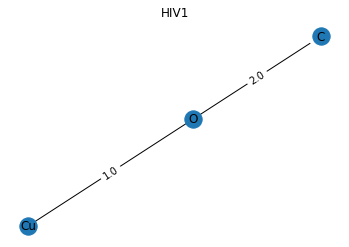

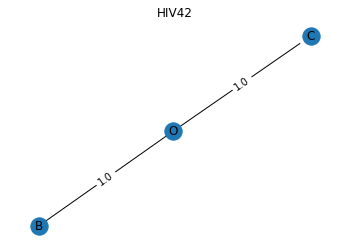

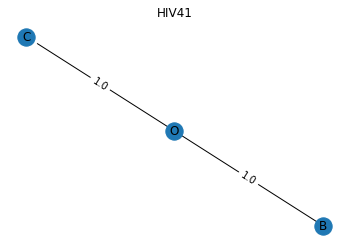

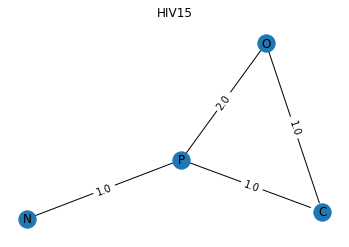

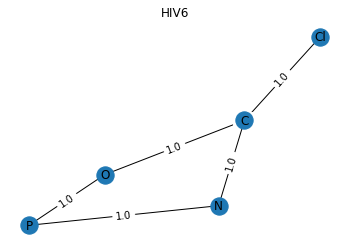

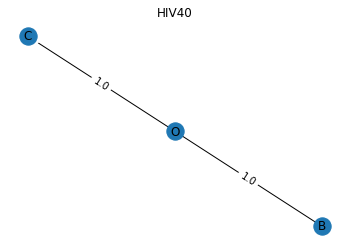

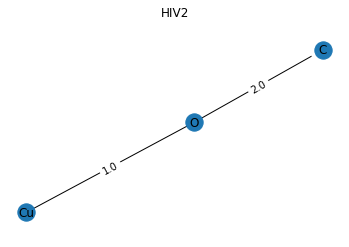

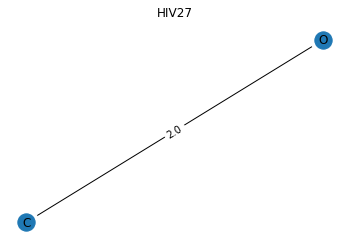

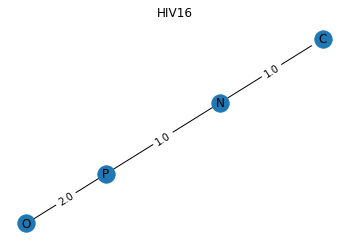

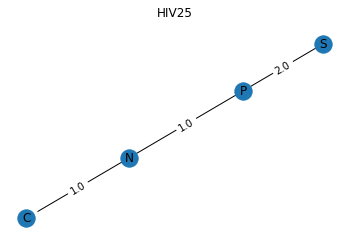

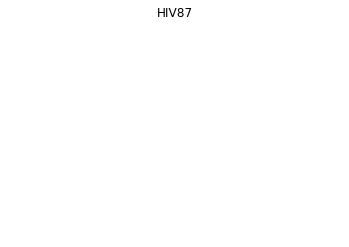

In [71]:
print("cos mode")
draw(top10_mode_cos, names_mode_cos, '', False)

cos except min max


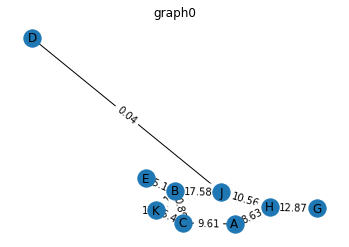

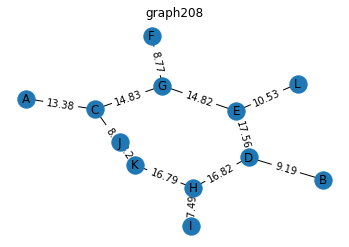

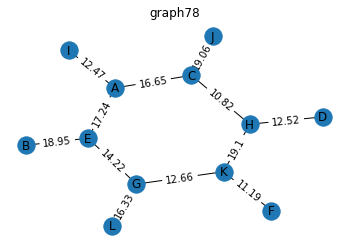

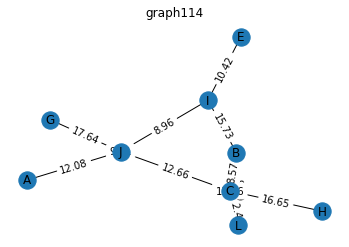

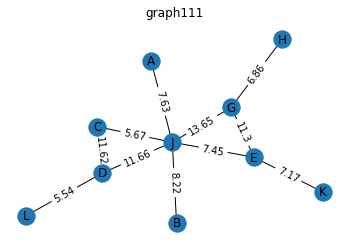

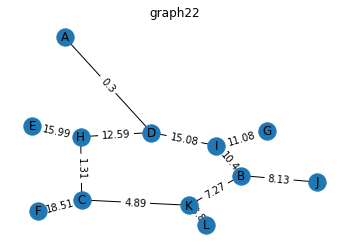

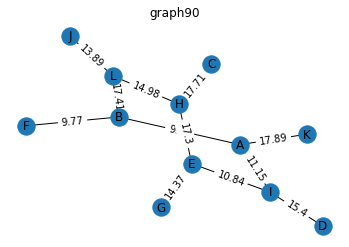

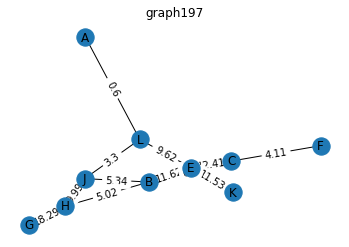

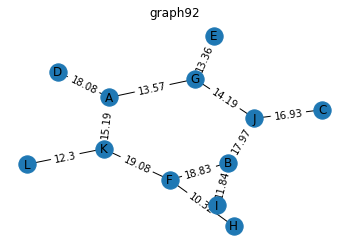

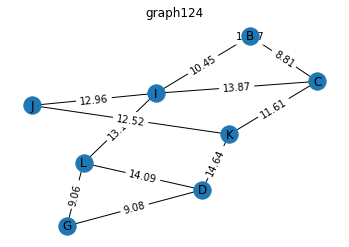

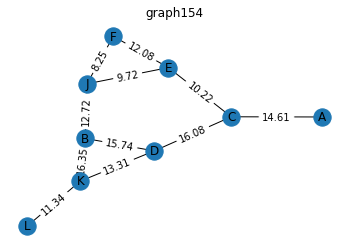

In [83]:
print("cos except min max")
draw(top10_except_cos, names_except_cos, '', False)

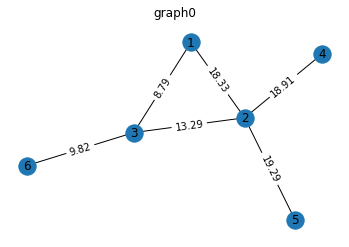

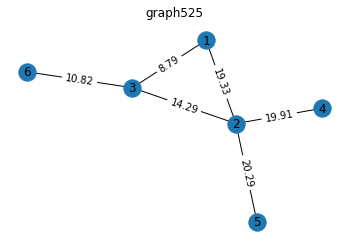

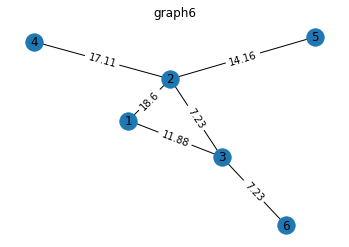

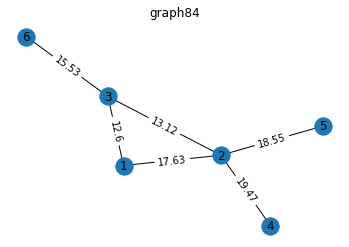

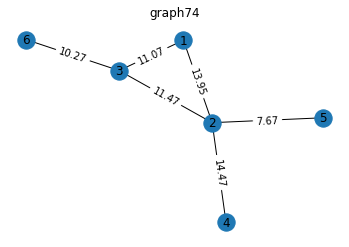

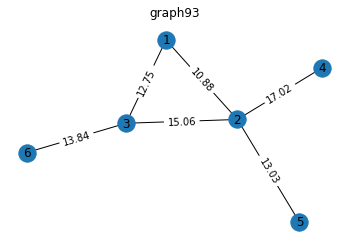

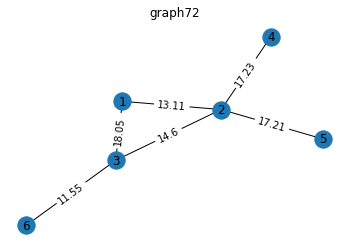

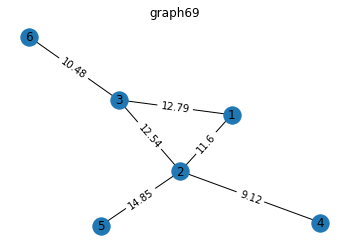

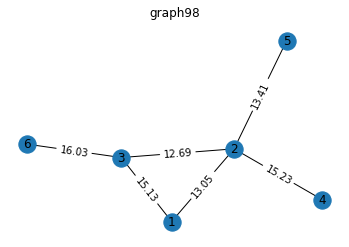

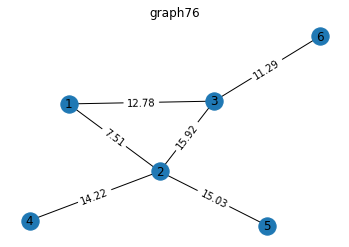

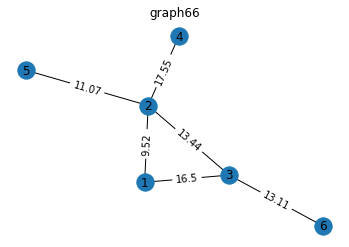

In [30]:
draw(top10_sum_cos, names_sum_cos, '', False)

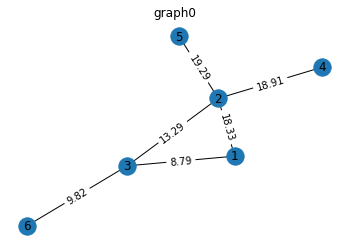

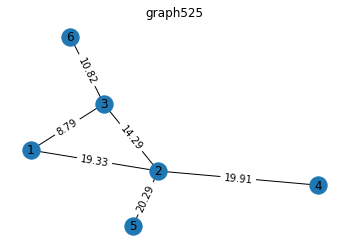

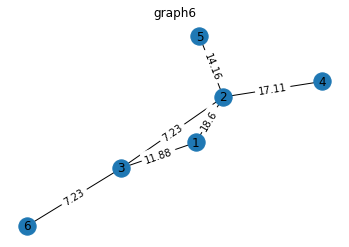

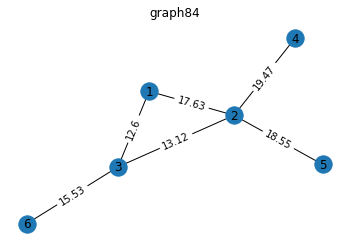

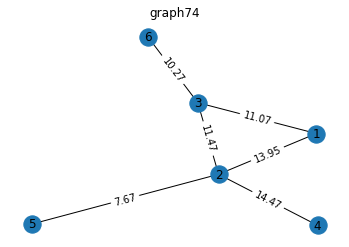

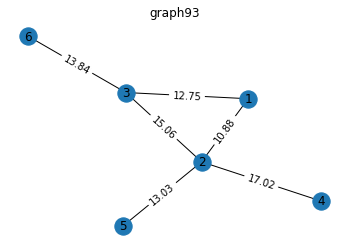

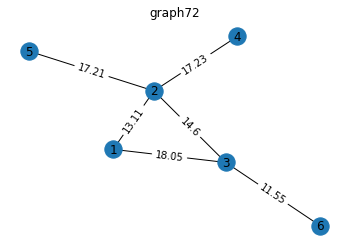

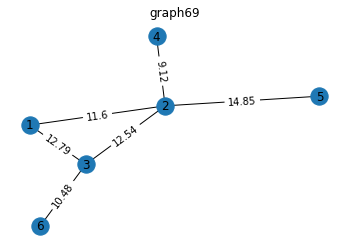

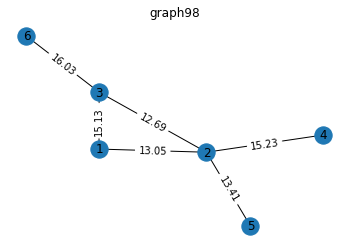

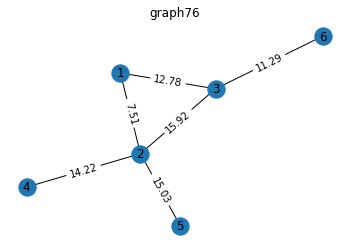

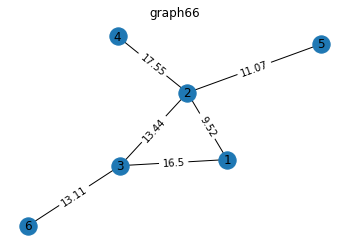

In [31]:
draw(top10_avg_cos, names_avg_cos, '', False)

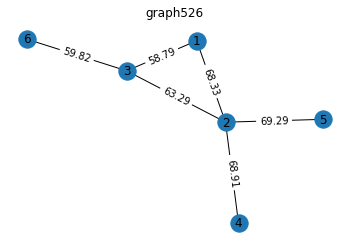

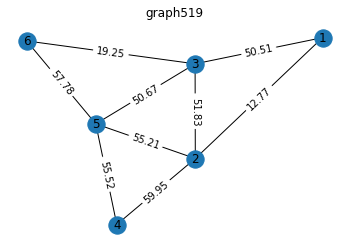

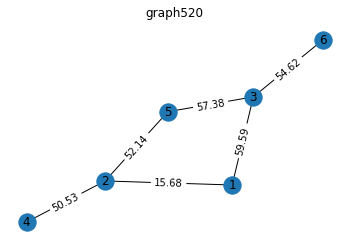

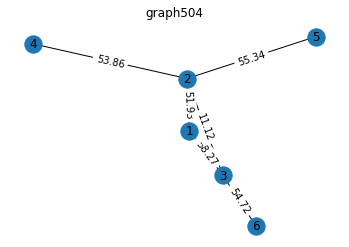

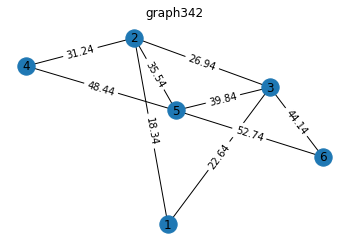

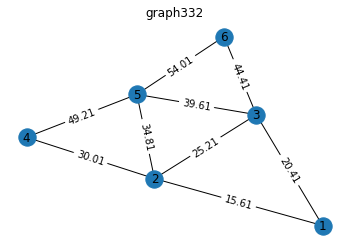

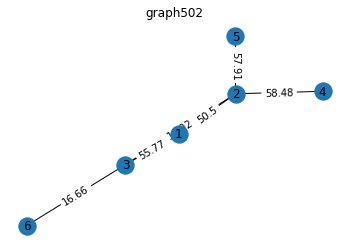

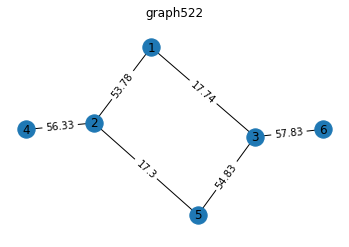

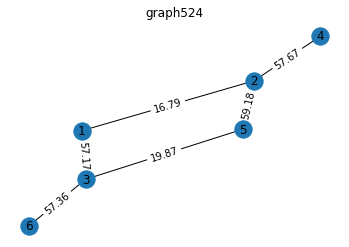

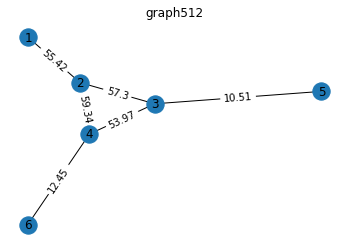

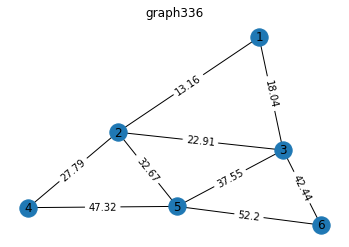

In [32]:
draw(back10_except_cos, names_except_cos[::-1], '', False)

In [449]:
result = np.array(except_embedding).reshape(600, 64)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.001s...
[t-SNE] Computed neighbors for 600 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 0.017357
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.794632
[t-SNE] KL divergence after 1000 iterations: 0.322257


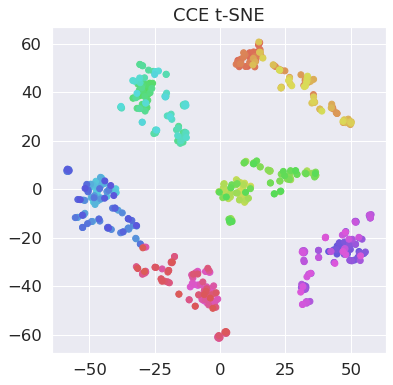

In [342]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
labels = [str(i) for i in range(len(result))]
tsne_train_xs = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000).fit_transform(result, labels)
plt.figure(figsize=(6, 6))
plt.scatter(x = tsne_train_xs[:,0], y=tsne_train_xs[:,1], color=sns.color_palette("hls", len(result)))


#for i in [0, 501, 525, 526]:
#    plt.annotate(str(i), (tsne_train_xs[i, 0], tsne_train_xs[i, 1]))

plt.title("CCE t-SNE")
plt.show()